<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%206/l1_%3D_0_005_l2_%3D_0_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


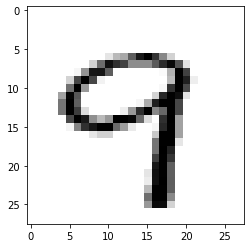

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

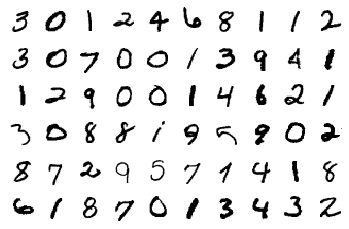

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # i/p= 28 o/p=26 r=3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # i/p=26  o/p=24 r=5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.05),
            
            nn.MaxPool2d(kernel_size=(2,2)), # i/p=24  o/p=12 r=6  

            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=12  o/p=10 r=10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),
            

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=10  o/p=8 r=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=8  o/p=6 r=18
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=6  o/p=4 r=22
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=4  o/p=2 r=26
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),


        ) 

    def forward(self, x):

        x = self.convblock1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_loss(model, data, factor):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss

In [0]:
def misclassified_images(misclassify):
  j=0
  fig = plt.figure(figsize=(15,15)) 
  for i in range(25): 
      ax = fig.add_subplot(5,5 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
      plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
      title = "Predicted: "+ str(misclassify[i][1][0].data.cpu().numpy())+" Target: "+ str(misclassify[i][2].data.cpu().numpy())
      ax.set_title(title) # give the class of the image as its title
      j+=1
  plt.subplots_adjust( hspace=0.5, wspace=0.35)      
  plt.show()

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassify = []

def train(model, device, train_loader, optimizer, epoch, use_l1 = False,l1_factor = 0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if use_l1 == True:
      loss += L1_loss(model,data,factor=l1_factor)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # output is the probability for each class
            
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassify.append([data[i],pred[i],target[i]])
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    # print("o === ",pred,"-------target = ",target,"output",output.shape)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # print(len(misclassify))
    # print(misclassify[0][0].size()) 
    test_acc.append(100. * correct / len(test_loader.dataset))

    # j=0
    # fig = plt.figure(figsize=(15,15)) 
    # for i in range(25): 
    #     ax = fig.add_subplot(7,4 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
    #     plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
    #     title = "predicted: "+ str(misclassify[i][1].data.cpu().numpy())+"target: "+ str(misclassify[i][2].data.cpu().numpy())
    #     ax.set_title(title) # give the class of the image as its title
    #     j+=1      
    # plt.show()

# Let's Train and test our model

In [13]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.11664152890443802 Batch_id=468 Accuracy=91.43: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9821/10000 (98.21%)

EPOCH: 1 lr =  0.01


Loss=0.13549241423606873 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:11<00:00, 42.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9857/10000 (98.57%)

EPOCH: 2 lr =  0.01


Loss=0.029480740427970886 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:11<00:00, 42.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9886/10000 (98.86%)

EPOCH: 3 lr =  0.01


Loss=0.04044756293296814 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:11<00:00, 42.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9906/10000 (99.06%)

EPOCH: 4 lr =  0.01


Loss=0.020420104265213013 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:11<00:00, 41.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)

EPOCH: 5 lr =  0.01


Loss=0.008560325019061565 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:11<00:00, 49.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9916/10000 (99.16%)

EPOCH: 6 lr =  0.001


Loss=0.015840137377381325 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 40.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 7 lr =  0.001


Loss=0.007716054562479258 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:11<00:00, 41.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 8 lr =  0.0001


Loss=0.0034737884998321533 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 9 lr =  0.0001


Loss=0.004655877593904734 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 41.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 10 lr =  0.0001


Loss=0.06587111204862595 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 11 lr =  0.0001


Loss=0.015533740632236004 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 42.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 12 lr =  1e-05


Loss=0.0724850669503212 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 13 lr =  1e-05


Loss=0.005009159445762634 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:10<00:00, 42.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 14 lr =  1e-05


Loss=0.0037320603150874376 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 41.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 15 lr =  1e-05


Loss=0.0070636942982673645 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 16 lr =  1e-05


Loss=0.039871592074632645 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 46.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 17 lr =  1e-05


Loss=0.009820058941841125 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 41.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 18 lr =  1e-05


Loss=0.033434849232435226 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:11<00:00, 42.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 19 lr =  1e-05


Loss=0.06414707750082016 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 42.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 20 lr =  1e-05


Loss=0.07610338181257248 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 21 lr =  1e-05


Loss=0.013126407749950886 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 42.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 22 lr =  1e-05


Loss=0.07143960148096085 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 42.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 23 lr =  1e-05


Loss=0.02094336785376072 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9938/10000 (99.38%)

EPOCH: 24 lr =  1e-05


Loss=0.04507458582520485 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 41.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

EPOCH: 25 lr =  1e-05


Loss=0.01523632276803255 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 42.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

EPOCH: 26 lr =  1e-05


Loss=0.042270440608263016 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 41.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 27 lr =  1e-05


Loss=0.058059368282556534 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 28 lr =  1e-05


Loss=0.009807939641177654 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:10<00:00, 42.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 29 lr =  1e-05


Loss=0.006170034408569336 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 30 lr =  1e-05


Loss=0.0573899932205677 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 40.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 31 lr =  1e-05


Loss=0.015388327650725842 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:10<00:00, 52.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 32 lr =  1e-05


Loss=0.022479256615042686 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 33 lr =  1e-05


Loss=0.0036184440832585096 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 34 lr =  1e-05


Loss=0.0036932528018951416 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 42.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 35 lr =  1e-05


Loss=0.010679970495402813 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:10<00:00, 42.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 36 lr =  1e-05


Loss=0.04406263306736946 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 45.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 37 lr =  1e-05


Loss=0.024339908733963966 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 42.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 38 lr =  1e-05


Loss=0.01660582423210144 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:10<00:00, 42.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 39 lr =  1e-05


Loss=0.0067938766442239285 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 41.93it/s]



Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)



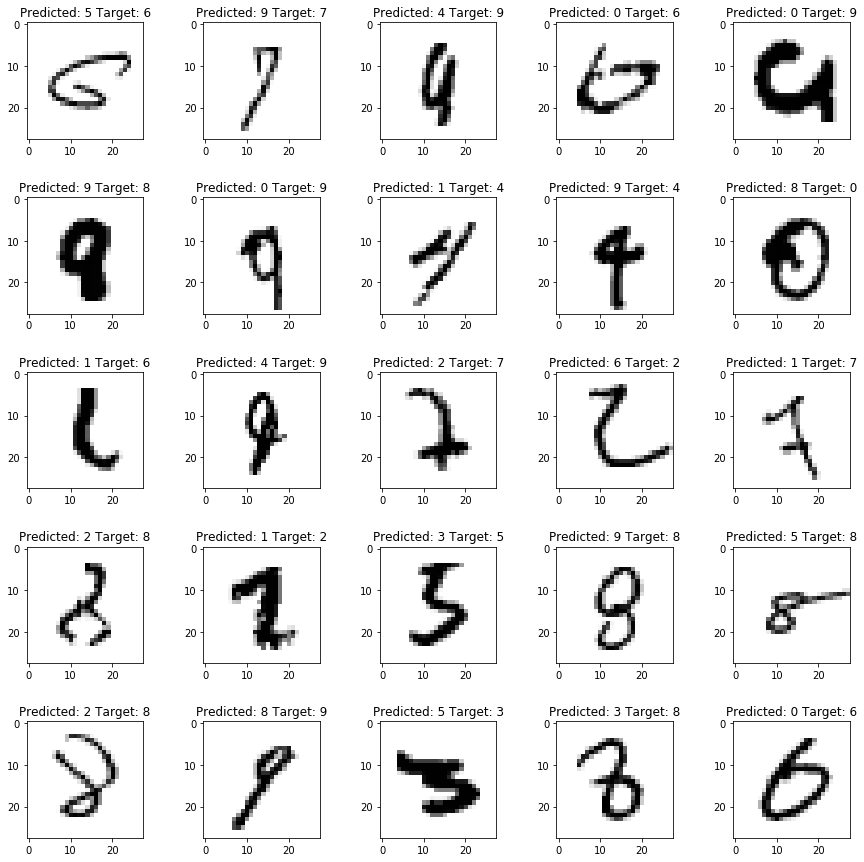

In [14]:
misclassified_images(misclassify)

In [0]:
train_acc_without_l1_l2 = train_acc.copy()
train_loss_without_l1_l2 = train_losses.copy()
test_acc_without_l1_l2 = test_acc.copy()
test_loss_without_l1_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

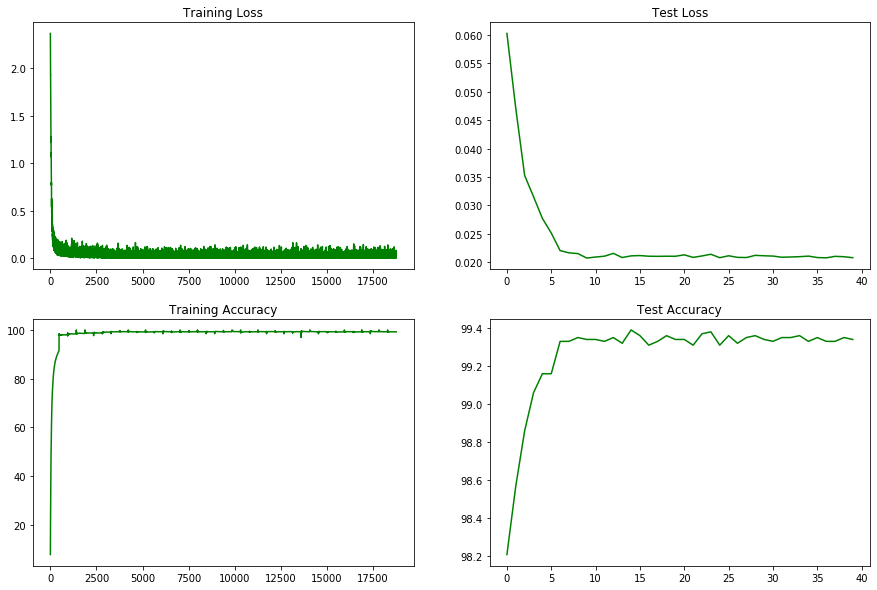

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g')
axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1**

In [35]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch,use_l1 = True,l1_factor=0.005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.1299131214618683 Batch_id=468 Accuracy=92.08: 100%|██████████| 469/469 [00:13<00:00, 41.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9830/10000 (98.30%)

EPOCH: 1 lr =  0.01


Loss=0.2253720760345459 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9886/10000 (98.86%)

EPOCH: 2 lr =  0.01


Loss=0.07859285175800323 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9877/10000 (98.77%)

EPOCH: 3 lr =  0.01


Loss=0.08101546764373779 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9908/10000 (99.08%)

EPOCH: 4 lr =  0.01


Loss=0.06432729214429855 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9904/10000 (99.04%)

EPOCH: 5 lr =  0.01


Loss=0.06917083263397217 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 44.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9896/10000 (98.96%)

EPOCH: 6 lr =  0.001


Loss=0.06934408843517303 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 42.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 7 lr =  0.001


Loss=0.05176103115081787 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

EPOCH: 8 lr =  0.0001


Loss=0.0426444411277771 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 9 lr =  0.0001


Loss=0.09648855030536652 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 10 lr =  0.0001


Loss=0.054250143468379974 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 11 lr =  0.0001


Loss=0.05296805128455162 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 12 lr =  1e-05


Loss=0.05237233638763428 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

EPOCH: 13 lr =  1e-05


Loss=0.06746475398540497 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 43.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 14 lr =  1e-05


Loss=0.07955821603536606 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 15 lr =  1e-05


Loss=0.04591928422451019 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 40.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 16 lr =  1e-05


Loss=0.058155693113803864 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 17 lr =  1e-05


Loss=0.0951898992061615 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 18 lr =  1e-05


Loss=0.08114320039749146 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 19 lr =  1e-05


Loss=0.04852714389562607 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 20 lr =  1e-05


Loss=0.0486074723303318 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 37.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 21 lr =  1e-05


Loss=0.06592586636543274 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 42.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

EPOCH: 22 lr =  1e-05


Loss=0.0637560710310936 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 23 lr =  1e-05


Loss=0.060955651104450226 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 40.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 24 lr =  1e-05


Loss=0.07331307232379913 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 25 lr =  1e-05


Loss=0.07689908146858215 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 40.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 26 lr =  1e-05


Loss=0.05201828479766846 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 27 lr =  1e-05


Loss=0.04531152918934822 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 28 lr =  1e-05


Loss=0.0643199235200882 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 29 lr =  1e-05


Loss=0.05260991305112839 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 30 lr =  1e-05


Loss=0.07720157504081726 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 31 lr =  1e-05


Loss=0.10232564806938171 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9931/10000 (99.31%)

EPOCH: 32 lr =  1e-05


Loss=0.048231665045022964 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

EPOCH: 33 lr =  1e-05


Loss=0.05596266686916351 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 34 lr =  1e-05


Loss=0.11766713857650757 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 45.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 35 lr =  1e-05


Loss=0.05119538679718971 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 36 lr =  1e-05


Loss=0.05650349706411362 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH: 37 lr =  1e-05


Loss=0.04642727971076965 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 38 lr =  1e-05


Loss=0.044725608080625534 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 39 lr =  1e-05


Loss=0.060736581683158875 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]



Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)



In [36]:
len(misclassify)

66

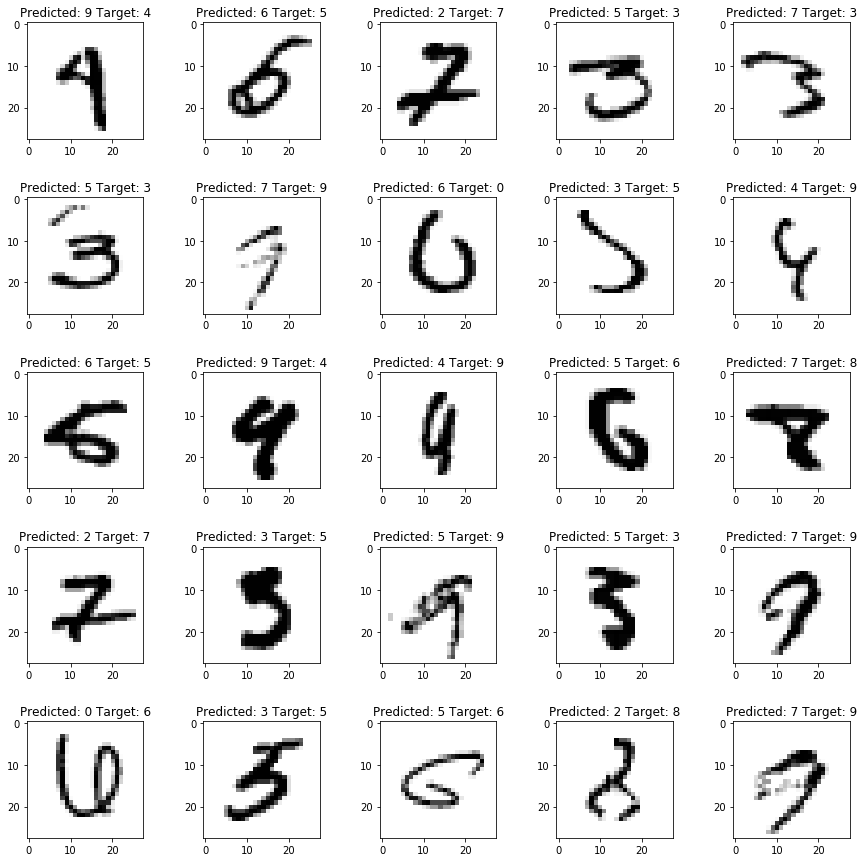

In [37]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1 = train_acc.copy()
train_loss_with_l1 = train_losses.copy()
test_acc_with_l1 = test_acc.copy()
test_loss_with_l1 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

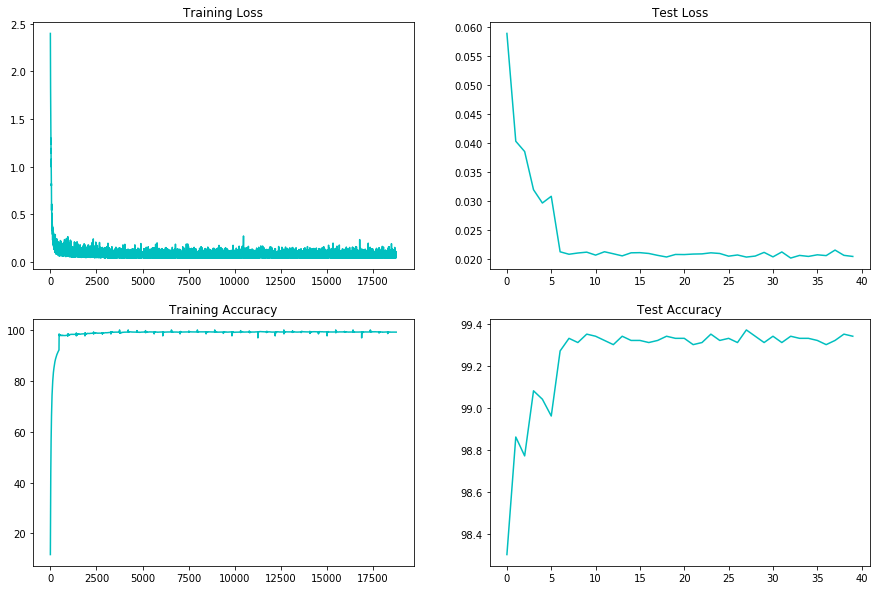

In [39]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_with_l1,color='c')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1,color='c')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1,color='c')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1,color='c')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L2**

In [41]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.005)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.09476365894079208 Batch_id=468 Accuracy=91.70: 100%|██████████| 469/469 [00:11<00:00, 51.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0956, Accuracy: 9749/10000 (97.49%)

EPOCH: 1 lr =  0.01


Loss=0.11058855056762695 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9862/10000 (98.62%)

EPOCH: 2 lr =  0.01


Loss=0.1218518614768982 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:12<00:00, 38.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9860/10000 (98.60%)

EPOCH: 3 lr =  0.01


Loss=0.13117684423923492 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 39.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9875/10000 (98.75%)

EPOCH: 4 lr =  0.01


Loss=0.08053811639547348 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9894/10000 (98.94%)

EPOCH: 5 lr =  0.01


Loss=0.03834560886025429 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:11<00:00, 39.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9860/10000 (98.60%)

EPOCH: 6 lr =  0.001


Loss=0.06978931277990341 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:11<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9938/10000 (99.38%)

EPOCH: 7 lr =  0.001


Loss=0.03544269874691963 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 51.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9936/10000 (99.36%)

EPOCH: 8 lr =  0.0001


Loss=0.04645746946334839 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9933/10000 (99.33%)

EPOCH: 9 lr =  0.0001


Loss=0.016088545322418213 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 40.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9936/10000 (99.36%)

EPOCH: 10 lr =  0.0001


Loss=0.032059792429208755 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 39.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9938/10000 (99.38%)

EPOCH: 11 lr =  0.0001


Loss=0.01792283169925213 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9937/10000 (99.37%)

EPOCH: 12 lr =  1e-05


Loss=0.03881623223423958 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 44.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9941/10000 (99.41%)

EPOCH: 13 lr =  1e-05


Loss=0.02601638436317444 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 40.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9938/10000 (99.38%)

EPOCH: 14 lr =  1e-05


Loss=0.02099626697599888 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9935/10000 (99.35%)

EPOCH: 15 lr =  1e-05


Loss=0.01910712756216526 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9933/10000 (99.33%)

EPOCH: 16 lr =  1e-05


Loss=0.02117980271577835 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 40.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9939/10000 (99.39%)

EPOCH: 17 lr =  1e-05


Loss=0.031334348022937775 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9936/10000 (99.36%)

EPOCH: 18 lr =  1e-05


Loss=0.025377975776791573 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9937/10000 (99.37%)

EPOCH: 19 lr =  1e-05


Loss=0.04892207309603691 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 50.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9938/10000 (99.38%)

EPOCH: 20 lr =  1e-05


Loss=0.051763251423835754 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9936/10000 (99.36%)

EPOCH: 21 lr =  1e-05


Loss=0.0347256101667881 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:11<00:00, 39.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9936/10000 (99.36%)

EPOCH: 22 lr =  1e-05


Loss=0.04500794783234596 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9936/10000 (99.36%)

EPOCH: 23 lr =  1e-05


Loss=0.044365812093019485 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:11<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9934/10000 (99.34%)

EPOCH: 24 lr =  1e-05


Loss=0.020360581576824188 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9934/10000 (99.34%)

EPOCH: 25 lr =  1e-05


Loss=0.024022961035370827 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9940/10000 (99.40%)

EPOCH: 26 lr =  1e-05


Loss=0.027034781873226166 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 49.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9937/10000 (99.37%)

EPOCH: 27 lr =  1e-05


Loss=0.030593276023864746 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9939/10000 (99.39%)

EPOCH: 28 lr =  1e-05


Loss=0.037010081112384796 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 41.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9937/10000 (99.37%)

EPOCH: 29 lr =  1e-05


Loss=0.022974038496613503 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9942/10000 (99.42%)

EPOCH: 30 lr =  1e-05


Loss=0.02973192185163498 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:11<00:00, 40.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9940/10000 (99.40%)

EPOCH: 31 lr =  1e-05


Loss=0.038465142250061035 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 39.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9936/10000 (99.36%)

EPOCH: 32 lr =  1e-05


Loss=0.037357136607170105 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 41.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9938/10000 (99.38%)

EPOCH: 33 lr =  1e-05


Loss=0.024770071730017662 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9936/10000 (99.36%)

EPOCH: 34 lr =  1e-05


Loss=0.031814780086278915 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9938/10000 (99.38%)

EPOCH: 35 lr =  1e-05


Loss=0.07798648625612259 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9934/10000 (99.34%)

EPOCH: 36 lr =  1e-05


Loss=0.028593435883522034 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9941/10000 (99.41%)

EPOCH: 37 lr =  1e-05


Loss=0.05644842982292175 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9941/10000 (99.41%)

EPOCH: 38 lr =  1e-05


Loss=0.04382967948913574 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9939/10000 (99.39%)

EPOCH: 39 lr =  1e-05


Loss=0.0993354320526123 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 39.91it/s]



Test set: Average loss: 0.0300, Accuracy: 9940/10000 (99.40%)



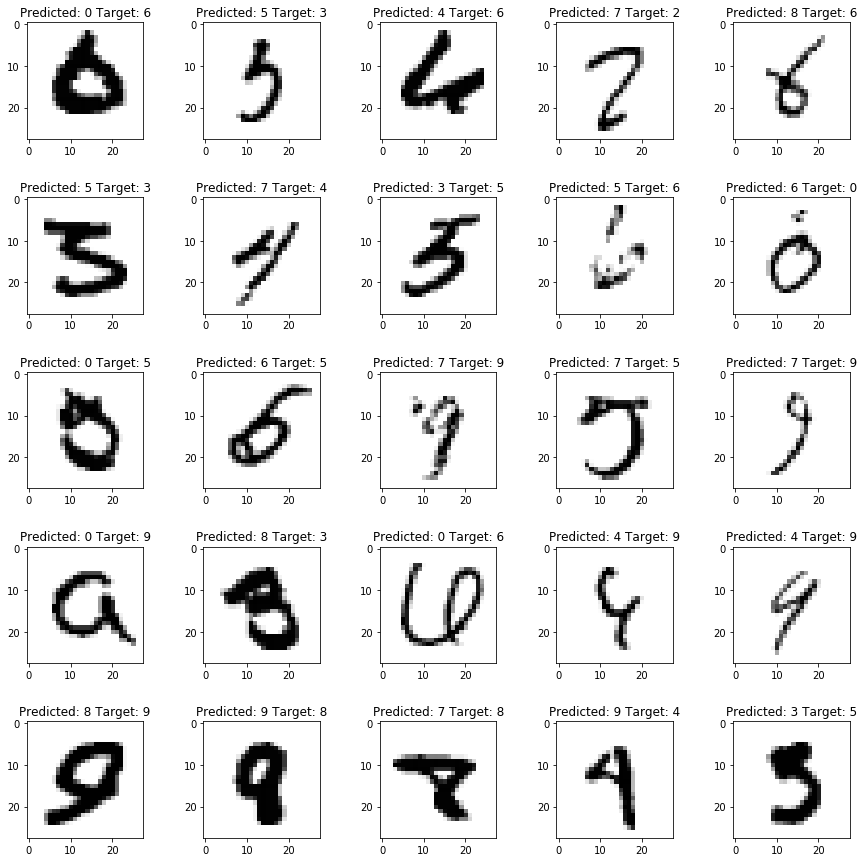

In [42]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l2 = train_acc.copy()
train_loss_with_l2 = train_losses.copy()
test_acc_with_l2 = test_acc.copy()
test_loss_with_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

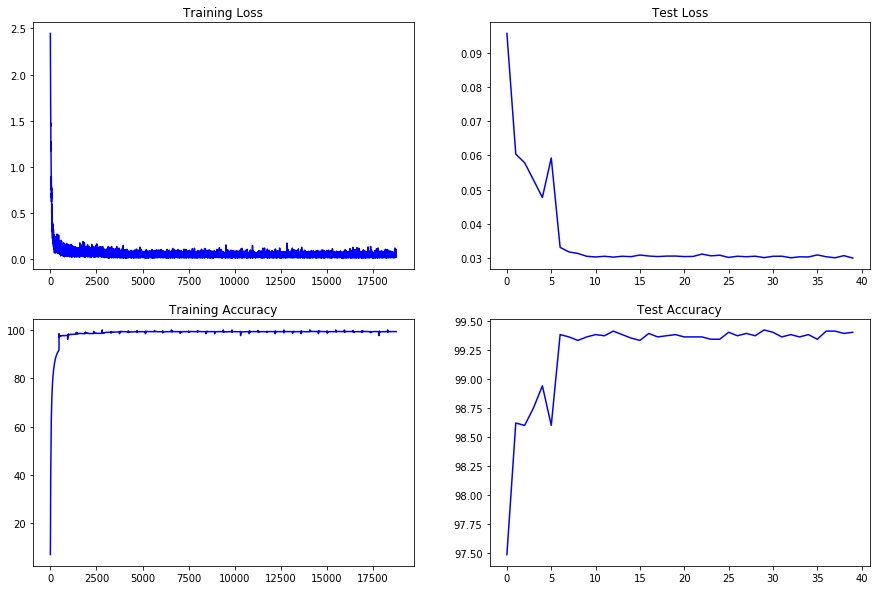

In [44]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l2,color = 'b')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l2,color = 'b')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l2,color = 'b')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l2,color = 'b')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1 and L2**

In [46]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.005)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch, use_l1 = True,l1_factor=0.005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.16422490775585175 Batch_id=468 Accuracy=90.97: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 9808/10000 (98.08%)

EPOCH: 1 lr =  0.01


Loss=0.2509375512599945 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9849/10000 (98.49%)

EPOCH: 2 lr =  0.01


Loss=0.06475148350000381 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9845/10000 (98.45%)

EPOCH: 3 lr =  0.01


Loss=0.1467999964952469 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:13<00:00, 34.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9879/10000 (98.79%)

EPOCH: 4 lr =  0.01


Loss=0.07786503434181213 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9885/10000 (98.85%)

EPOCH: 5 lr =  0.01


Loss=0.07392200082540512 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9863/10000 (98.63%)

EPOCH: 6 lr =  0.001


Loss=0.048042841255664825 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 42.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9931/10000 (99.31%)

EPOCH: 7 lr =  0.001


Loss=0.059901416301727295 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 40.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9922/10000 (99.22%)

EPOCH: 8 lr =  0.0001


Loss=0.03623751178383827 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9934/10000 (99.34%)

EPOCH: 9 lr =  0.0001


Loss=0.05094273015856743 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 39.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9928/10000 (99.28%)

EPOCH: 10 lr =  0.0001


Loss=0.03426538035273552 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9934/10000 (99.34%)

EPOCH: 11 lr =  0.0001


Loss=0.055824216455221176 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 33.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9933/10000 (99.33%)

EPOCH: 12 lr =  1e-05


Loss=0.0676925852894783 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9933/10000 (99.33%)

EPOCH: 13 lr =  1e-05


Loss=0.04476996883749962 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9930/10000 (99.30%)

EPOCH: 14 lr =  1e-05


Loss=0.04166482761502266 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9933/10000 (99.33%)

EPOCH: 15 lr =  1e-05


Loss=0.0946253091096878 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9924/10000 (99.24%)

EPOCH: 16 lr =  1e-05


Loss=0.046699561178684235 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 42.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9933/10000 (99.33%)

EPOCH: 17 lr =  1e-05


Loss=0.044066619127988815 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9930/10000 (99.30%)

EPOCH: 18 lr =  1e-05


Loss=0.09928768873214722 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 43.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9931/10000 (99.31%)

EPOCH: 19 lr =  1e-05


Loss=0.03612353652715683 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9929/10000 (99.29%)

EPOCH: 20 lr =  1e-05


Loss=0.03861397132277489 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9934/10000 (99.34%)

EPOCH: 21 lr =  1e-05


Loss=0.09043349325656891 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9929/10000 (99.29%)

EPOCH: 22 lr =  1e-05


Loss=0.08132839947938919 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9931/10000 (99.31%)

EPOCH: 23 lr =  1e-05


Loss=0.10626567900180817 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 33.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9934/10000 (99.34%)

EPOCH: 24 lr =  1e-05


Loss=0.04497969150543213 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9931/10000 (99.31%)

EPOCH: 25 lr =  1e-05


Loss=0.12382484972476959 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9928/10000 (99.28%)

EPOCH: 26 lr =  1e-05


Loss=0.04271508753299713 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9928/10000 (99.28%)

EPOCH: 27 lr =  1e-05


Loss=0.047058746218681335 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 38.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9930/10000 (99.30%)

EPOCH: 28 lr =  1e-05


Loss=0.06408705562353134 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9931/10000 (99.31%)

EPOCH: 29 lr =  1e-05


Loss=0.059043340384960175 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9931/10000 (99.31%)

EPOCH: 30 lr =  1e-05


Loss=0.0481702983379364 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9932/10000 (99.32%)

EPOCH: 31 lr =  1e-05


Loss=0.06650526821613312 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 43.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9931/10000 (99.31%)

EPOCH: 32 lr =  1e-05


Loss=0.04369021952152252 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9932/10000 (99.32%)

EPOCH: 33 lr =  1e-05


Loss=0.03560568392276764 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9930/10000 (99.30%)

EPOCH: 34 lr =  1e-05


Loss=0.10690001398324966 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 41.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9932/10000 (99.32%)

EPOCH: 35 lr =  1e-05


Loss=0.042396172881126404 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9935/10000 (99.35%)

EPOCH: 36 lr =  1e-05


Loss=0.05651930719614029 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9930/10000 (99.30%)

EPOCH: 37 lr =  1e-05


Loss=0.03893657401204109 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 46.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9931/10000 (99.31%)

EPOCH: 38 lr =  1e-05


Loss=0.07730293273925781 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9931/10000 (99.31%)

EPOCH: 39 lr =  1e-05


Loss=0.03976906090974808 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]



Test set: Average loss: 0.0332, Accuracy: 9930/10000 (99.30%)



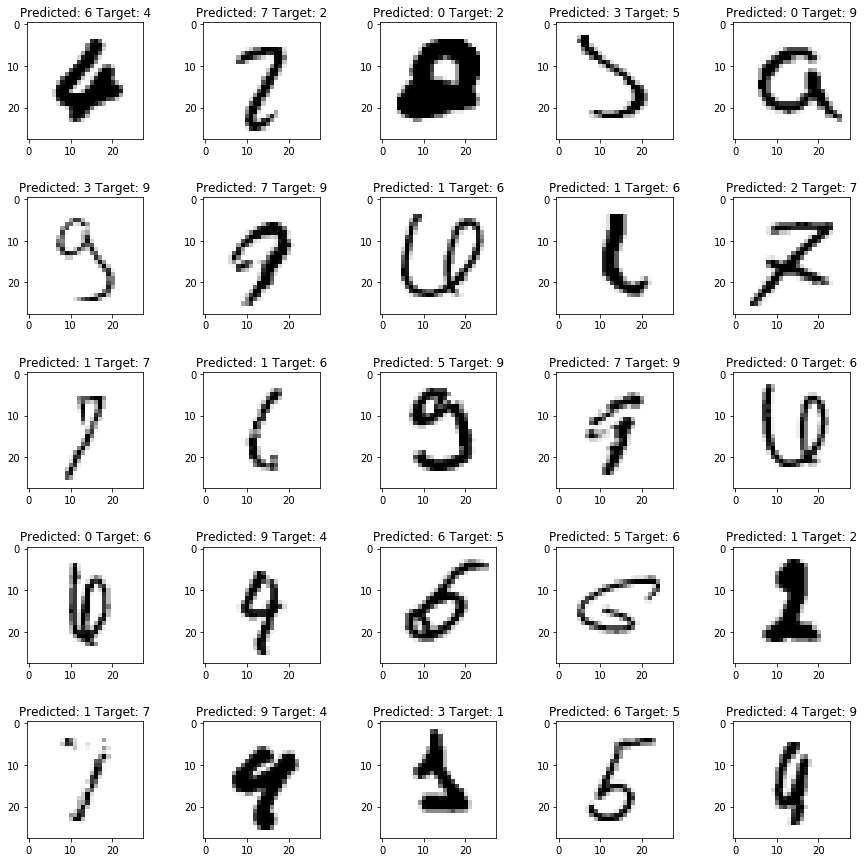

In [47]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1_l2 = train_acc.copy()
train_loss_with_l1_l2 = train_losses.copy()
test_acc_with_l1_l2 = test_acc.copy()
test_loss_with_l1_l2 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

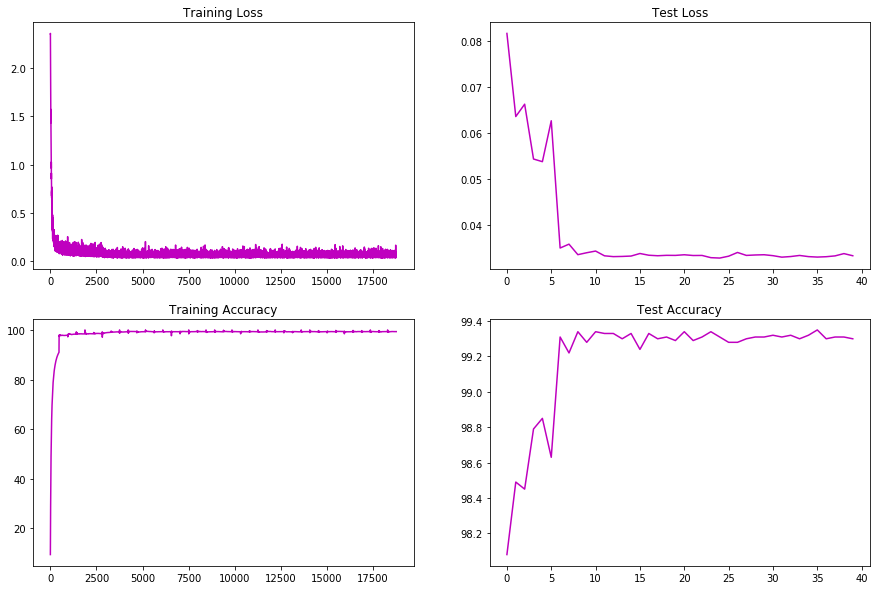

In [49]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l1_l2,color = 'm')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1_l2,color = 'm')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1_l2,color = 'm')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1_l2,color = 'm')

axs[1, 1].set_title("Test Accuracy")

Text(0.5, 0.98, 'l1 = 0.005, l2 = 0.005')

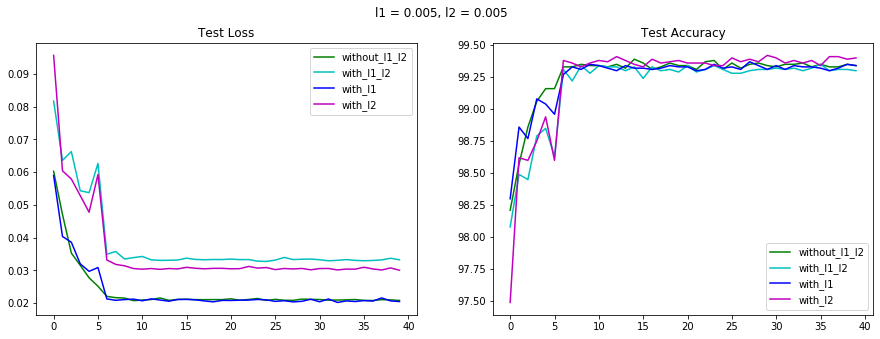

In [51]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1].set_title("Test Accuracy")
axs[1].legend()
fig.suptitle("l1 = 0.005, l2 = 0.005")